# React Agent Simulation using LangGraph

In [20]:
import sys
import os
from langgraph.graph import StateGraph
from app.config.config import Configuration
from langchain_deepseek import ChatDeepSeek
from langchain_tavily import TavilySearch
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


In [21]:
# Add project root to sys.path
sys.path.append(os.path.abspath("../.."))

# --- Configuration and Tool Setup ---
config = Configuration()

## 1.Create some basic tools

In [22]:
def multiply(a: float, b: float) -> float:
    """Multiply a and b (supports int and float).

    Args:
        a: first int or float
        b: second int or float
    """
    return float(a) * float(b)

# This will be a tool
def add(a: float, b: float) -> float:
    """Adds a and b (supports int and float).

    Args:
        a: first int or float
        b: second int or float
    """
    return float(a) + float(b)

def divide(a: float, b: float) -> float:
    """Divide a and b (supports int and float).

    Args:
        a: first int or float
        b: second int or float
    """
    return float(a) / float(b)

In [23]:
os.environ["TAVILY_API_KEY"] = config.TAVILY_API_KEY
web_search_tool = TavilySearch(max_results=5, topic="general", include_answer=True)

In [24]:
llm = ChatDeepSeek(api_key=config.DEEPSEEK_API_KEY, model="deepseek-chat")

tools = [web_search_tool, multiply, add, divide]
llm_with_tools = llm.bind_tools(tools)

In [25]:
from langgraph.graph import MessagesState

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## 2.Build the Graph

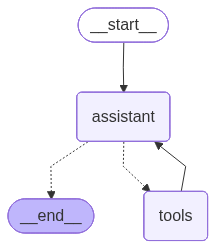

In [26]:
from langgraph.constants import START, END
from IPython.core.display import Image
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node(assistant, "assistant")
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)

builder.add_edge("tools", "assistant")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


## 3.Run the Graph

In [27]:
messages = [HumanMessage(content="What's the weight of the Earth?")]

messages = react_graph.invoke({"messages": messages})

In [28]:
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What's the weight of the Earth?
================================== Ai Message ==================================

I'll search for information about the Earth's weight to provide you with an accurate answer.
Tool Calls:
  tavily_search (call_00_kopkcXHhxuDdV0c79K3g8WXs)
 Call ID: call_00_kopkcXHhxuDdV0c79K3g8WXs
  Args:
    query: weight of the Earth mass kilograms
================================= Tool Message =================================
Name: tavily_search

{"query": "weight of the Earth mass kilograms", "follow_up_questions": null, "answer": "Earth's mass is approximately 5.972 × 10²⁴ kilograms. This figure is derived from gravitational measurements and scientific calculations.", "images": [], "results": [{"url": "https://coolcosmos.ipac.caltech.edu/ask/61-How-much-does-Earth-weigh-and-how-is-this-measured-", "title": "How much does Earth weigh and how is this measured?", "content": "Earth weighs 

In [29]:
messages = [HumanMessage(content="What's 400 multiplied by 5000, then later divided by 21.75?")]
messages = react_graph.invoke({"messages": messages})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What's 400 multiplied by 5000, then later divded by 21.75?
================================== Ai Message ==================================

I'll help you calculate this step by step. First, let's multiply 400 by 5000:
Tool Calls:
  multiply (call_00_RyY0Y2kI9QE8NOWbfkH1WR40)
 Call ID: call_00_RyY0Y2kI9QE8NOWbfkH1WR40
  Args:
    a: 400
    b: 5000
================================= Tool Message =================================
Name: multiply

2000000.0
================================== Ai Message ==================================

Now, let's divide the result (2,000,000) by 21.75:
Tool Calls:
  divide (call_00_h2j7qb38GQjsrkEEmBaKEYJT)
 Call ID: call_00_h2j7qb38GQjsrkEEmBaKEYJT
  Args:
    a: 2000000
    b: 21.75
================================= Tool Message =================================
Name: divide

91954.02298850575
================================== Ai Message =================================

## 4.Add Grading the response to the Agent

In [30]:
from langchain_community.chat_models.tongyi import ChatTongyi
llm_grader = ChatTongyi(dashscope_api_key=config.DASHSCOPE_API_KEY)

def grade_with_tongyi(state: MessagesState):
    """Grade the assistant's response with detailed evaluation criteria"""
    messages = state["messages"]

    # Get the original question (first human message)
    question = next((msg.content for msg in messages if isinstance(msg, HumanMessage)), "")

    # Get the last assistant response
    response = next((msg.content for msg in reversed(messages) if isinstance(msg, AIMessage)), "")

    grading_prompt = f"""You are an expert evaluator assessing AI assistant responses. Evaluate the following response based on these criteria:
    **Question:** {question}

    **Response:** {response}

    **Evaluation Criteria:**
    1. **Accuracy**: Is the answer factually correct? Are calculations accurate?
    2. **Completeness**: Does it fully address all parts of the question?
    3. **Clarity**: Is the explanation clear and easy to understand?
    4. **Relevance**: Does it stay on topic without unnecessary information?

    **Instructions:**
    - Provide a verdict: "CORRECT" or "INCORRECT"
    - Give a confidence score (0-100%)
    - Explain your reasoning in 2-3 sentences
    - Point out specific issues if incorrect

    **Format your response as:**
    Verdict: [CORRECT/INCORRECT]
    Confidence: [0-100]%
    Reasoning: [Your explanation]"""

    grading_result = llm_grader.invoke(grading_prompt)

    # Return the grading result as a new message
    return {"messages": [AIMessage(content=f"Grading Result:\n{grading_result.content}")]}

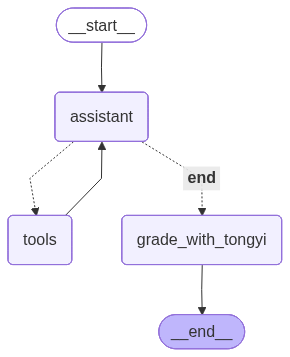

In [31]:
from langgraph.constants import START
from IPython.core.display import Image
from langgraph.prebuilt import ToolNode, tools_condition

builder_1 = StateGraph(MessagesState)
builder_1.add_node(assistant, "assistant")
builder_1.add_node("tools", ToolNode(tools))
builder_1.add_node("grade_with_tongyi", grade_with_tongyi)

builder_1.add_edge(START, "assistant")
builder_1.add_conditional_edges("assistant", tools_condition,{"tools": "tools", "__end__": "grade_with_tongyi"})

builder_1.add_edge("tools", "assistant")
builder_1.add_edge("grade_with_tongyi", END)
react_graph_1 = builder_1.compile()

display(Image(react_graph_1.get_graph(xray=True).draw_mermaid_png()))

In [32]:
messages = [HumanMessage(content="What's 400 multiplied by 5000, then later divded by 21.75?")]
messages = react_graph_1.invoke({"messages": messages})
for message in messages['messages']:
    message.pretty_print()



================================ Human Message =================================

What's 400 multiplied by 5000, then later divded by 21.75?
================================== Ai Message ==================================

I'll help you calculate this step by step. First, I'll multiply 400 by 5000, then divide that result by 21.75.
Tool Calls:
  multiply (call_00_G2zeFgNuOOeCXH5rRCU0nkEK)
 Call ID: call_00_G2zeFgNuOOeCXH5rRCU0nkEK
  Args:
    a: 400
    b: 5000
================================= Tool Message =================================
Name: multiply

2000000.0
================================== Ai Message ==================================

Now I'll divide the result (2,000,000) by 21.75:
Tool Calls:
  divide (call_00_oX1TLnWIw7IdnuplDQZlmcgK)
 Call ID: call_00_oX1TLnWIw7IdnuplDQZlmcgK
  Args:
    a: 2000000
    b: 21.75
================================= Tool Message =================================
Name: divide

91954.02298850575
================================== Ai Message ==

## 5.Self-reflection Agent

In [33]:
# Verdict routing function for self-reflection
def verdict_router(state):
    # Find the last grading result message
    grading_msg = next((msg for msg in reversed(state["messages"]) if isinstance(msg, AIMessage) and "Grading Result:" in msg.content), None)
    if grading_msg:
        # Extract verdict from grading result
        verdict_line = next((line for line in grading_msg.content.splitlines() if "Verdict:" in line), "")
        verdict = verdict_line.split(":")[-1].strip().upper()
        if verdict == "INCORRECT":
            return "assistant"
        elif verdict == "CORRECT":
            return END
    # Default: end if verdict not found
    return END

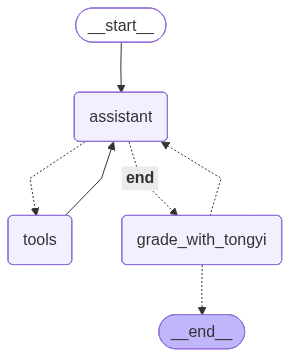

In [34]:
from langgraph.constants import START
from IPython.core.display import Image
from langgraph.prebuilt import ToolNode, tools_condition

builder_2 = StateGraph(MessagesState)
builder_2.add_node(assistant, "assistant")
builder_2.add_node("tools", ToolNode(tools))
builder_2.add_node("grade_with_tongyi", grade_with_tongyi)

builder_2.add_edge(START, "assistant")
builder_2.add_conditional_edges("assistant", tools_condition, {"tools": "tools", "__end__": "grade_with_tongyi"})

builder_2.add_edge("tools", "assistant")

# Based on Verdict[CORRECT/INCORRECT] from the response of grade_with_tongyi node, to decide to loop back to assistant or end
builder_2.add_conditional_edges("grade_with_tongyi", verdict_router, {"assistant": "assistant", "__end__": END})
react_graph_2 = builder_2.compile()

display(Image(react_graph_2.get_graph(xray=True).draw_mermaid_png()))

In [35]:
messages = [HumanMessage(content="Luxun killed ZhouShuRen.")]

messages = react_graph_2.invoke({"messages": messages})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Luxun killed ZhouShuRen.
================================== Ai Message ==================================

I understand you're mentioning a historical reference involving Lu Xun and Zhou Shuren. However, I should clarify that Lu Xun and Zhou Shuren are actually the same person - Zhou Shuren was Lu Xun's real name, and Lu Xun was his pen name. He was one of China's most influential 20th-century writers.

If you're looking for information about Lu Xun's life, works, or historical context, I'd be happy to help you search for that information. Would you like me to look up details about Lu Xun's biography, literary contributions, or the historical period he lived in?
================================== Ai Message ==================================

Grading Result:
Verdict: INCORRECT  
Confidence: 70%  
Reasoning: The response correctly identifies that Lu Xun and Zhou Shuren are the same person, which is factual

## 6.Explain Tool Results

In [36]:
def summarize_tool_results(messages):
    explanations = []
    for msg in messages['messages']:
        if getattr(msg, 'role', None) == 'tool':
            content = msg.content
            if isinstance(content, dict) and 'answer' in content:
                explanations.append(f"Web search found: {content['answer']}")
            else:
                explanations.append(f"Calculation result: {content}")
    return "\n".join(explanations)

def answer_references_tool(final_answer):
    keywords = ["based on", "according to", "web search", "calculation", "tool result"]
    return any(kw in final_answer.lower() for kw in keywords)

def explain_tool_results_to_user(messages, final_answer):
    tool_explanation = summarize_tool_results(messages)
    if tool_explanation and answer_references_tool(final_answer):
        print("\nI used the following tools to help answer your question:")
        print(tool_explanation)
        print(f"\nFinal Answer (with context):\n{final_answer}")
        print("\nExplanation: The above answer references tool results. Here is what each tool did:")
        for idx, line in enumerate(tool_explanation.splitlines(), 1):
            print(f"  Tool {idx}: {line}")
        print("\nIf you want more details about any tool result, just ask!")
    elif tool_explanation:
        print("\nHere are the tool results used in reasoning:")
        print(tool_explanation)
        print(f"\nFinal Answer:\n{final_answer}")
    else:
        print(f"\nFinal Answer:\n{final_answer}")

# After running the graph and before grading
final_answer = messages['messages'][-1].content if messages['messages'] else ""
explain_tool_results_to_user(messages, final_answer)

# If the final answer references tool results, always show the tool results to the user for transparency
if answer_references_tool(final_answer) and summarize_tool_results(messages):
    print("\nFor your reference, here are the tool results that contributed to the answer above:")
    print(summarize_tool_results(messages))
    print("\nIf you want a detailed explanation of any tool result, just ask and I will provide it!")



Final Answer:
Grading Result:
Verdict: CORRECT  
Confidence: 100%  
Reasoning: The response accurately clarifies that Lu Xun and Zhou Shuren are the same person, correctly identifying Zhou Shuren as his real name and Lu Xun as his pen name. It also correctly states that Lu Xun died of natural causes in 1936, and it appropriately addresses the factual inaccuracy in the original question. The response is clear, relevant, and fully addresses the user's statement.
